In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from scipy import stats
from scipy.special import expit as logistic
from scipy.special import softmax

In [4]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
plt.style.use("dark_background")

%watermark -n -u -v -iv -w

Last updated: Sat Aug 20 2022

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

scipy     : 1.8.1
matplotlib: 3.5.2
numpy     : 1.22.4
sys       : 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) 
[Clang 13.0.1 ]
pymc      : 4.1.3
pandas    : 1.4.3
arviz     : 0.12.1

Watermark: 2.3.1



11.1 logistic / bionimial regression

In [3]:
d = pd.read_csv("Data/chimpanzees.csv", sep=';')
d

actor  recipient  condition  block  trial  prosoc_left  chose_prosoc  \
0        1        NaN          0      1      2            0             1   
1        1        NaN          0      1      4            0             0   
2        1        NaN          0      1      6            1             0   
3        1        NaN          0      1      8            0             1   
4        1        NaN          0      1     10            1             1   
..     ...        ...        ...    ...    ...          ...           ...   
499      7        4.0          1      6     64            1             1   
500      7        6.0          1      6     66            1             1   
501      7        3.0          1      6     68            0             0   
502      7        7.0          1      6     70            0             0   
503      7        2.0          1      6     72            0             0   

     pulled_left  
0              0  
1              1  
2              0  
3              0  
4              1  
..           ...  
499            1  
500            1  
501            1  
502            1  
503            1  

[504 rows x 8 columns]

In [5]:
d["actor"] -= 1
## condition and prosoc_left binary encoding combine into treatment idx
d["treatment"] = d["prosoc_left"] + 2*d["condition"]
d

actor  recipient  condition  block  trial  prosoc_left  chose_prosoc  \
0        0        NaN          0      1      2            0             1   
1        0        NaN          0      1      4            0             0   
2        0        NaN          0      1      6            1             0   
3        0        NaN          0      1      8            0             1   
4        0        NaN          0      1     10            1             1   
..     ...        ...        ...    ...    ...          ...           ...   
499      6        4.0          1      6     64            1             1   
500      6        6.0          1      6     66            1             1   
501      6        3.0          1      6     68            0             0   
502      6        7.0          1      6     70            0             0   
503      6        2.0          1      6     72            0             0   

     pulled_left  treatment  
0              0          0  
1              1          0  
2              0          1  
3              0          0  
4              1          1  
..           ...        ...  
499            1          3  
500            1          3  
501            1          2  
502            1          2  
503            1          2  

[504 rows x 9 columns]

In [6]:
d.groupby("treatment").first()

actor  recipient  condition  block  trial  prosoc_left  \
treatment                                                           
0              0        NaN          0      1      2            0   
1              0        NaN          0      1      6            1   
2              0        8.0          1      1      1            0   
3              0        5.0          1      1      5            1   

           chose_prosoc  pulled_left  
treatment                             
0                     1            0  
1                     0            0  
2                     0            1  
3                     0            0

In [10]:
## intercept only to test priors
with pm.Model() as m1a:
    ## at a = 0, p = 0.5
    a = pm.Normal("a", 0, 10)
    p = pm.Deterministic("p", pm.math.invlogit(a))
    ## bernoulli likelihood
    L = pm.Binomial("pulled_left", 1, p, observed=d["pulled_left"])
    prior1a = pm.sample_prior_predictive()

with pm.Model() as m1b:
    ## a closer to 0, p closer to 0.5
    a = pm.Normal("a", 0, 1.5)
    p = pm.Deterministic("p", pm.math.invlogit(a))
    L = pm.Binomial("pulled_left", 1, p, observed=d["pulled_left"])
    prior1b = pm.sample_prior_predictive()

<AxesSubplot:>

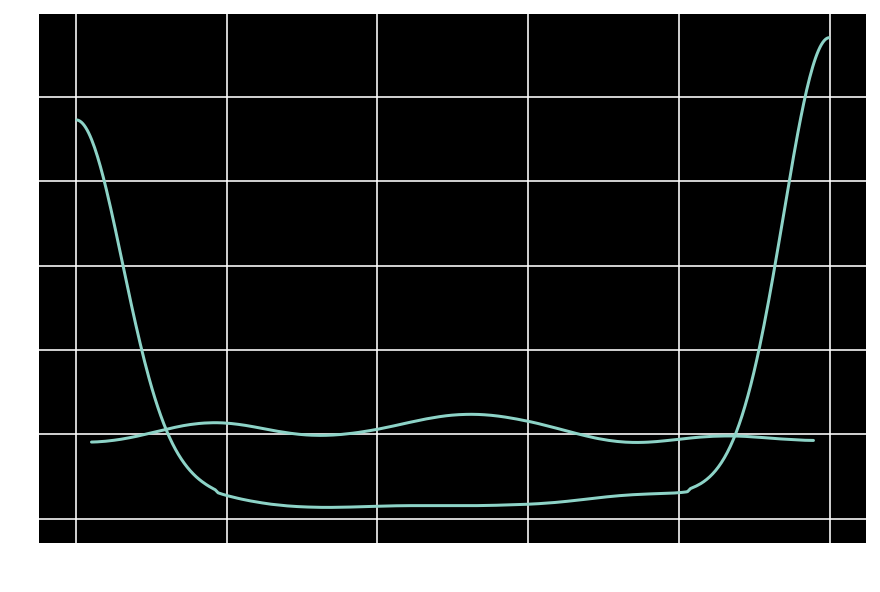

In [11]:
_, ax = plt.subplots()
az.plot_dist(prior1a.prior["p"], ax=ax)
az.plot_dist(prior1b.prior["p"], ax=ax)

In [81]:
## prior for treatment effect
treatment_id, treatment_levels = pd.factorize(d["treatment"])

with pm.Model() as m2a:
    a = pm.Normal("a", 0, 1.5)
    b = pm.Normal("b", 0, 10, shape=treatment_levels.size)
    p = pm.Deterministic("p", pm.math.invlogit(a + b[treatment_id]))
    L = pm.Binomial("pulled_left", 1, p, observed=d["pulled_left"])
    prior2a = pm.sample_prior_predictive()

with pm.Model() as m2b:
    ## a closer to 0, p closer to 0.5
    a = pm.Normal("a", 0, 1.5)
    b = pm.Normal("b", 0, 0.5, shape=treatment_levels.size)
    p = pm.Deterministic("p", pm.math.invlogit(a + b[treatment_id]))
    L = pm.Binomial("pulled_left", 1, p, observed=d["pulled_left"])
    prior2b = pm.sample_prior_predictive()

<AxesSubplot:>

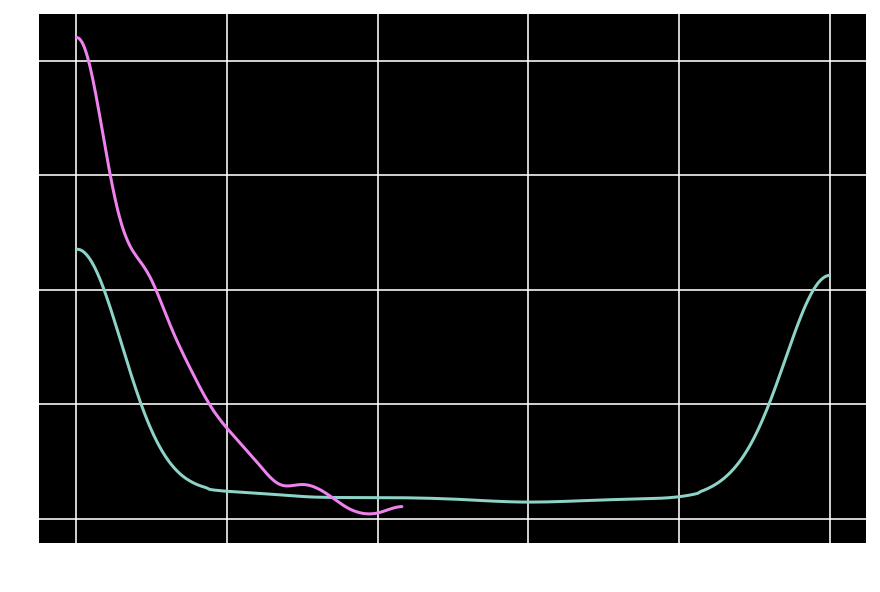

In [82]:
ptreat0a = prior2a.prior["p"][0,:,treatment_id==0].mean("p_dim_0")
ptreat1a = prior2a.prior["p"][0,:,treatment_id==1].mean("p_dim_0")
ptreat0b = prior2b.prior["p"][0,:,treatment_id==0].mean("p_dim_0")
ptreat1b = prior2b.prior["p"][0,:,treatment_id==1].mean("p_dim_0")

_, ax = plt.subplots()
az.plot_dist(np.abs(ptreat0a - ptreat1a), ax=ax)
az.plot_dist(np.abs(ptreat0b - ptreat1b), ax=ax, color="violet")


In [84]:
actor_id, actor_levels = pd.factorize(d["actor"])

## note: actor and treatment have additive effects, no interaction
with pm.Model() as m4:
    a = pm.Normal("a", 0, 1.5, shape=actor_levels.size)
    b = pm.Normal("b", 0, 0.5, shape=treatment_levels.size)
    p = pm.Deterministic("p", pm.math.invlogit(a[actor_id] + b[treatment_id]))
    L = pm.Binomial("pulled_left", 1, p, observed=d["pulled_left"])
    trace4 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


In [86]:
az.summary(trace4, var_names=["~p"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a[0] -0.456  0.335  -1.084    0.182      0.008    0.005    1944.0    2721.0   
a[1]  3.885  0.750   2.585    5.354      0.014    0.010    3166.0    2072.0   
a[2] -0.759  0.336  -1.395   -0.140      0.008    0.006    1823.0    2268.0   
a[3] -0.755  0.334  -1.376   -0.123      0.008    0.005    1939.0    2508.0   
a[4] -0.457  0.334  -1.052    0.206      0.008    0.005    1891.0    2497.0   
a[5]  0.468  0.338  -0.143    1.118      0.008    0.006    1814.0    2379.0   
a[6]  1.944  0.415   1.192    2.745      0.009    0.006    2310.0    2912.0   
b[0] -0.036  0.291  -0.583    0.519      0.007    0.005    1805.0    2470.0   
b[1]  0.489  0.285  -0.052    1.020      0.007    0.005    1754.0    2708.0   
b[2] -0.377  0.290  -0.912    0.162      0.007    0.005    1681.0    2703.0   
b[3]  0.378  0.287  -0.139    0.934      0.007    0.005    1693.0    2579.0   

      r_hat  
a[0]    1.0  
a[1]    1.0  
a[2]    1.0  
a[3]    1.0  
a[4]    1.0  
a[5]    1.0  
a[6]    1.0  
b[0]    1.0  
b[1]    1.0  
b[2]    1.0  
b[3]    1.0

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

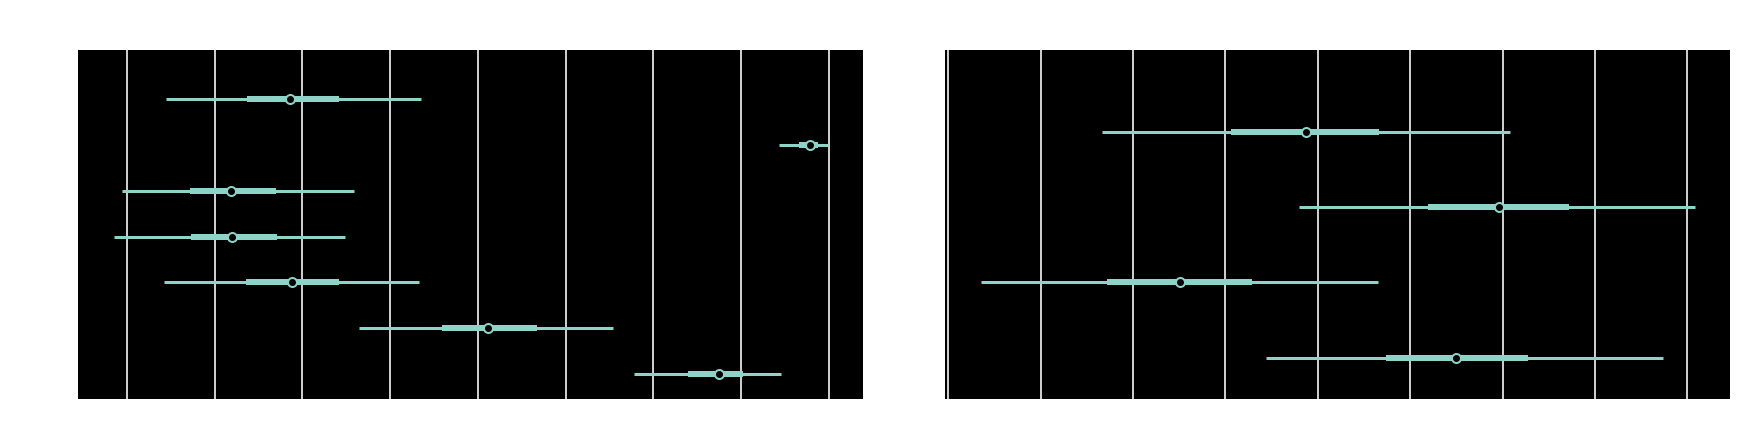

In [93]:
_, ax = plt.subplots(1,2,figsize=[12,3])
az.plot_forest(trace4, var_names=["a"], transform=logistic, combined=True, ax=ax[0])
az.plot_forest(trace4, var_names=["b"], combined=True, ax=ax[1])

In [104]:
print(trace4.posterior["b"].sel(b_dim_0=0))
print(trace4.posterior["b"][:,:,0])

<xarray.DataArray 'b' (chain: 4, draw: 1000)>
array([[ 0.29913199,  0.13520472,  0.19962958, ..., -0.1363709 ,
         0.01856031,  0.35679769],
       [-0.03751742,  0.26572101,  0.16999521, ..., -0.12584921,
        -0.5844843 , -0.41974748],
       [ 0.34272291, -0.21270798, -0.12914029, ..., -0.30653459,
         0.24995523,  0.29106596],
       [-0.10701039, -0.36107007, -0.26712168, ...,  0.09465135,
        -0.33235992,  0.06749132]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
    b_dim_0  int64 0
<xarray.DataArray 'b' (chain: 4, draw: 1000)>
array([[ 0.29913199,  0.13520472,  0.19962958, ..., -0.1363709 ,
         0.01856031,  0.35679769],
       [-0.03751742,  0.26572101,  0.16999521, ..., -0.12584921,
        -0.5844843 , -0.41974748],
       [ 0.34272291, -0.21270798, -0.12914029, ..., -0.30653459,
         0.24995523,  0.29106596],
       [-0.10701039, -0.36107007, -0.26712168, ...,  0.094

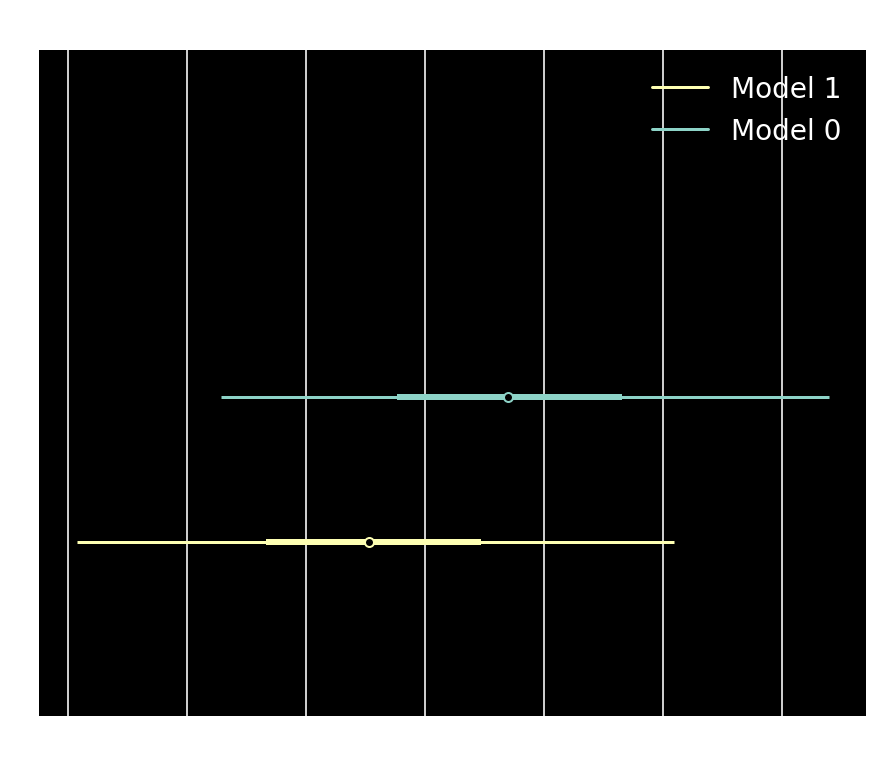

In [107]:
db02 = trace4.posterior["b"][:,:,0] - trace4.posterior["b"][:,:,2]
db13 = trace4.posterior["b"][:,:,1] - trace4.posterior["b"][:,:,3]
az.plot_forest([db02, db13], combined=True);

In [118]:
d.groupby(["actor","treatment"]).mean()

recipient  condition     block      trial  prosoc_left  \
actor treatment                                                           
0     0                NaN        0.0  3.500000  36.444444          0.0   
      1                NaN        0.0  3.500000  37.555556          1.0   
      2           5.500000        1.0  3.055556  31.666667          0.0   
      3           5.500000        1.0  3.944444  40.333333          1.0   
1     0                NaN        0.0  3.500000  35.777778          0.0   
      1                NaN        0.0  3.500000  36.222222          1.0   
      2           5.333333        1.0  3.055556  28.055556          0.0   
      3           5.333333        1.0  3.944444  42.444444          1.0   
2     0                NaN        0.0  3.500000  35.777778          0.0   
      1                NaN        0.0  3.500000  36.222222          1.0   
      2           5.166667        1.0  3.833333  40.888889          0.0   
      3           5.166667        1.0  3.166667  33.111111          1.0   
3     0                NaN        0.0  3.500000  35.666667          0.0   
      1                NaN        0.0  3.500000  36.333333          1.0   
      2           5.000000        1.0  3.555556  37.444444          0.0   
      3           5.000000        1.0  3.444444  36.555556          1.0   
4     0                NaN        0.0  3.500000  38.111111          0.0   
      1                NaN        0.0  3.500000  35.888889          1.0   
      2           4.833333        1.0  3.444444  35.555556          0.0   
      3           4.833333        1.0  3.555556  36.444444          1.0   
5     0                NaN        0.0  3.500000  36.555556          0.0   
      1                NaN        0.0  3.500000  37.444444          1.0   
      2           4.666667        1.0  3.722222  38.666667          0.0   
      3           4.666667        1.0  3.277778  33.333333          1.0   
6     0                NaN        0.0  3.500000  35.222222          0.0   
      1                NaN        0.0  3.500000  36.777778          1.0   
      2           4.500000        1.0  3.611111  38.666667          0.0   
      3           4.500000        1.0  3.388889  35.333333          1.0   

                 chose_prosoc  pulled_left  
actor treatment                             
0     0              0.666667     0.333333  
      1              0.500000     0.500000  
      2              0.722222     0.277778  
      3              0.555556     0.555556  
1     0              0.000000     1.000000  
      1              1.000000     1.000000  
      2              0.000000     1.000000  
      3              1.000000     1.000000  
2     0              0.722222     0.277778  
      1              0.611111     0.611111  
      2              0.833333     0.166667  
      3              0.333333     0.333333  
3     0              0.666667     0.333333  
      1              0.500000     0.500000  
      2              0.888889     0.111111  
      3              0.444444     0.444444  
4     0              0.666667     0.333333  
      1              0.555556     0.555556  
      2              0.722222     0.277778  
      3              0.500000     0.500000  
5     0              0.222222     0.777778  
      1              0.611111     0.611111  
      2              0.444444     0.555556  
      3              0.611111     0.611111  
6     0              0.222222     0.777778  
      1              0.833333     0.833333  
      2              0.055556     0.944444  
      3              1.000000     1.000000

In [121]:
left_by_AT = d.groupby(["actor","treatment"]).mean()["pulled_left"]
left_by_AT

actor  treatment
0      0            0.333333
       1            0.500000
       2            0.277778
       3            0.555556
1      0            1.000000
       1            1.000000
       2            1.000000
       3            1.000000
2      0            0.277778
       1            0.611111
       2            0.166667
       3            0.333333
3      0            0.333333
       1            0.500000
       2            0.111111
       3            0.444444
4      0            0.333333
       1            0.555556
       2            0.277778
       3            0.500000
5      0            0.777778
       1            0.611111
       2            0.555556
       3            0.611111
6      0            0.777778
       1            0.833333
       2            0.944444
       3            1.000000
Name: pulled_left, dtype: float64

In [120]:
d.groupby(["actor","treatment"]).mean()["pulled_left"].unstack()

treatment         0         1         2         3
actor                                            
0          0.333333  0.500000  0.277778  0.555556
1          1.000000  1.000000  1.000000  1.000000
2          0.277778  0.611111  0.166667  0.333333
3          0.333333  0.500000  0.111111  0.444444
4          0.333333  0.555556  0.277778  0.500000
5          0.777778  0.611111  0.555556  0.611111
6          0.777778  0.833333  0.944444  1.000000

In [158]:
trace4.posterior["p"][:,:,(actor_id==2) & (treatment_id==2)].mean(["chain","draw"])

<xarray.DataArray 'p' (p_dim_0: 18)>
array([0.24723682, 0.24723682, 0.24723682, 0.24723682, 0.24723682,
       0.24723682, 0.24723682, 0.24723682, 0.24723682, 0.24723682,
       0.24723682, 0.24723682, 0.24723682, 0.24723682, 0.24723682,
       0.24723682, 0.24723682, 0.24723682])
Coordinates:
  * p_dim_0  (p_dim_0) int64 181 183 185 188 192 194 ... 206 210 211 212 214 215

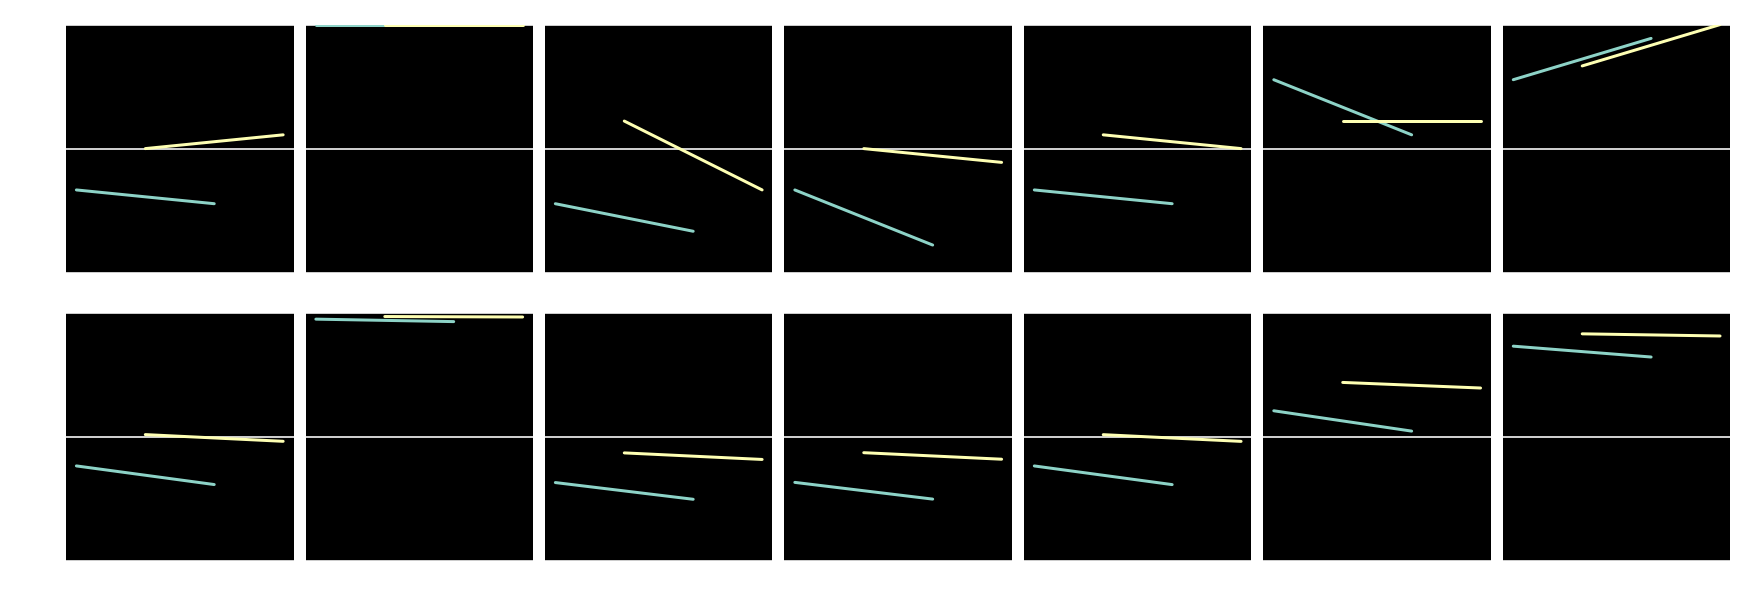

In [298]:
_, ax = plt.subplots(2, actor_levels.size, figsize=[12,4], sharey=True)#, sharex=True)
for a in actor_levels:
    ax[0,a].set_xticks([])
    ax[1,a].set_xticks([])
    ax[0,a].set_ylim(0,1)
    ax[1,a].set_ylim(0,1)
    ax[0,a].set_yticks([0,0.5,1])
    ax[1,a].set_yticks([0,0.5,1])
    ax[0,a].plot([0, 2], [left_by_AT[a,0], left_by_AT[a,2]])
    ax[0,a].plot([1, 3], [left_by_AT[a,1], left_by_AT[a,3]])
    ax[1,a].plot([0, 2], [
        trace4.posterior["p"][:,:,(actor_id==a) & (treatment_id==0)].mean(),
        trace4.posterior["p"][:,:,(actor_id==a) & (treatment_id==2)].mean(),
        ])
    ax[1,a].plot([1, 3], [
        trace4.posterior["p"][:,:,(actor_id==a) & (treatment_id==1)].mean(),
        trace4.posterior["p"][:,:,(actor_id==a) & (treatment_id==3)].mean(),
        ])

aggregated binomial

In [199]:
d[["treatment","actor","pulled_left"]].groupby(["treatment","actor"]).sum().head()

pulled_left
treatment actor             
0         0                6
          1               18
          2                5
          3                6
          4                6

In [213]:
da = d[["treatment","actor","pulled_left"]].groupby(["treatment","actor"],as_index=False).sum()
da.head()

treatment  actor  pulled_left
0          0      0            6
1          0      1           18
2          0      2            5
3          0      3            6
4          0      4            6

In [214]:
with pm.Model() as m6:
    a = pm.Normal("a", 0, 1.5, shape=actor_levels.size)
    b = pm.Normal("b", 0, 0.5, shape=treatment_levels.size)
    p = pm.Deterministic("p", pm.math.invlogit(a[da.actor] + b[da.treatment]))
    L = pm.Binomial("pulled_left", 18, p, observed=da["pulled_left"])
    trace6 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [215]:
az.summary(trace6,var_names=["a","b"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a[0] -0.452  0.325  -1.074    0.158      0.007    0.005    1891.0    2982.0   
a[1]  3.909  0.760   2.513    5.294      0.012    0.009    4103.0    2321.0   
a[2] -0.753  0.331  -1.356   -0.124      0.008    0.006    1777.0    2725.0   
a[3] -0.749  0.337  -1.377   -0.113      0.008    0.006    1800.0    2331.0   
a[4] -0.452  0.329  -1.083    0.140      0.008    0.005    1850.0    2979.0   
a[5]  0.464  0.332  -0.122    1.118      0.008    0.005    1880.0    2617.0   
a[6]  1.953  0.411   1.234    2.764      0.008    0.006    2363.0    2685.0   
b[0] -0.038  0.284  -0.563    0.504      0.007    0.005    1566.0    2302.0   
b[1]  0.483  0.285  -0.074    0.989      0.007    0.005    1635.0    2692.0   
b[2] -0.380  0.285  -0.927    0.146      0.007    0.005    1675.0    2216.0   
b[3]  0.375  0.284  -0.168    0.893      0.007    0.005    1551.0    2174.0   

      r_hat  
a[0]    1.0  
a[1]    1.0  
a[2]    1.0  
a[3]    1.0  
a[4]    1.0  
a[5]    1.0  
a[6]    1.0  
b[0]    1.0  
b[1]    1.0  
b[2]    1.0  
b[3]    1.0

11.1.4 one predictor vs two predictors (not an interaction)

In [342]:
d = pd.read_csv("Data/UCBadmit.csv", sep=';')
d.head()

dept applicant.gender  admit  reject  applications
1    A             male    512     313           825
2    A           female     89      19           108
3    B             male    353     207           560
4    B           female     17       8            25
5    C             male    120     205           325

In [343]:
gid, genders = pd.factorize(d["applicant.gender"])
deptid, depts = pd.factorize(d["dept"])
print(gid, genders)

[0 1 0 1 0 1 0 1 0 1 0 1] Index(['male', 'female'], dtype='object')


In [345]:
## gender only model
with pm.Model() as m7:
    a = pm.Normal("a", 0, 1.5, shape=len(genders))
    p = pm.Deterministic("p", pm.math.invlogit(a[gid]))
    ## N = applications, p = logistic(a[gender]), x = admit
    admit = pm.Binomial("admit", d["applications"], p, observed=d["admit"])
    trace7 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [346]:
az.summary(trace7, var_names=["a"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a[0] -0.22  0.039   -0.29   -0.142      0.001    0.000    4170.0    3071.0   
a[1] -0.83  0.051   -0.93   -0.734      0.001    0.001    4276.0    3213.0   

      r_hat  
a[0]    1.0  
a[1]    1.0

In [347]:
## exp(a) is on proportional odds scale
## p is on the outcome scale (0 - 1 prob)

## use az.summary on derived values
az.summary({
    "diff_a": trace7.posterior["a"][:,:,0] - trace7.posterior["a"][:,:,1],
    "odds_m": np.exp(trace7.posterior["a"][:,:,0]),
    "odds_f": np.exp(trace7.posterior["a"][:,:,1]),
    "prop odds": np.exp(trace7.posterior["a"][:,:,0] - trace7.posterior["a"][:,:,1]),
    ## p_dim_0 is genders*departments
    "p_m": trace7.posterior["p"][:,:,(gid==0)].mean("p_dim_0"),
    "p_f": trace7.posterior["p"][:,:,(gid==1)].mean("p_dim_0"),
    "diff_p": trace7.posterior["p"][:,:,(gid==0)].mean("p_dim_0") - trace7.posterior["p"][:,:,(gid==1)].mean("p_dim_0")
    }, kind="stats")

mean     sd  hdi_3%  hdi_97%
diff_a     0.609  0.064   0.487    0.726
odds_m     0.803  0.031   0.742    0.860
odds_f     0.437  0.022   0.392    0.477
prop odds  1.843  0.119   1.627    2.067
p_m        0.445  0.010   0.428    0.464
p_f        0.304  0.011   0.282    0.323
diff_p     0.141  0.014   0.114    0.168

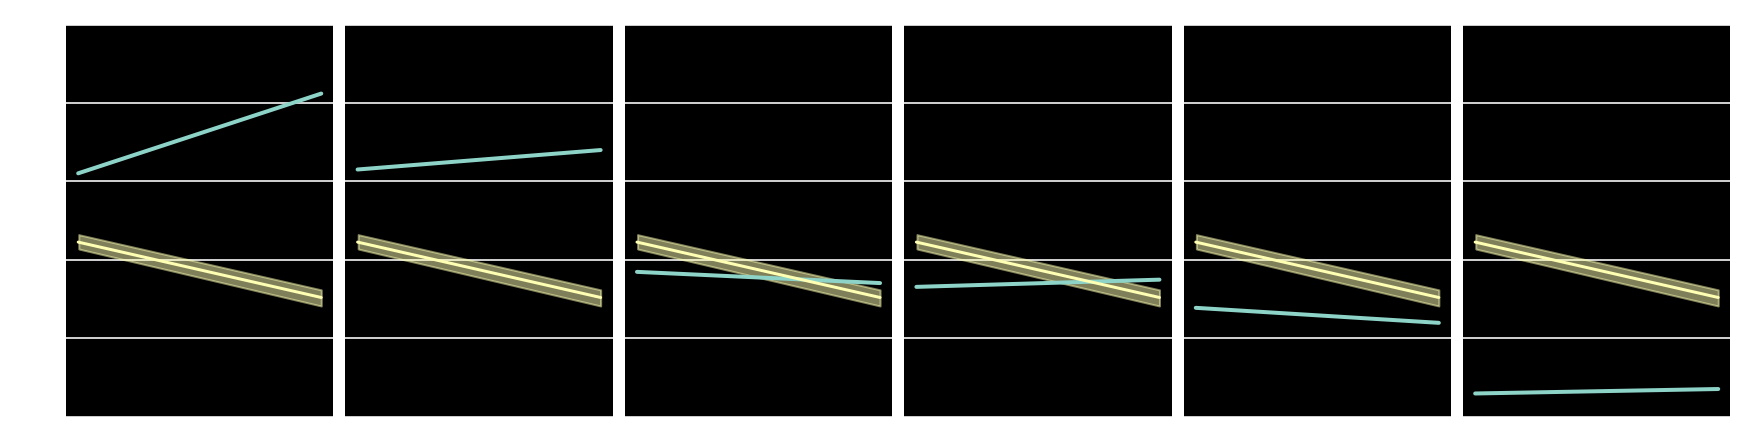

In [348]:
## observed p vs model p
_, ax = plt.subplots(1, len(depts), figsize=[12,3], sharey=True)
for i, x in enumerate(depts):
    ax[i].set_xticks([])
    ax[i].set_ylim(0,1)
    ax[i].plot([0,1], d[(d["dept"]==x)]["admit"] / d[(d["dept"]==x)]["applications"], lw=2)
    ax[i].plot([0,1], trace7.posterior["p"][:,:,(deptid==i)].mean(["chain","draw"]))
    az.plot_hdi([0,1],trace7.posterior["p"][:,:,(deptid==i)], ax=ax[i])

In [349]:
pp7 = pm.sample_posterior_predictive(trace7, model=m7, var_names=["admit"])

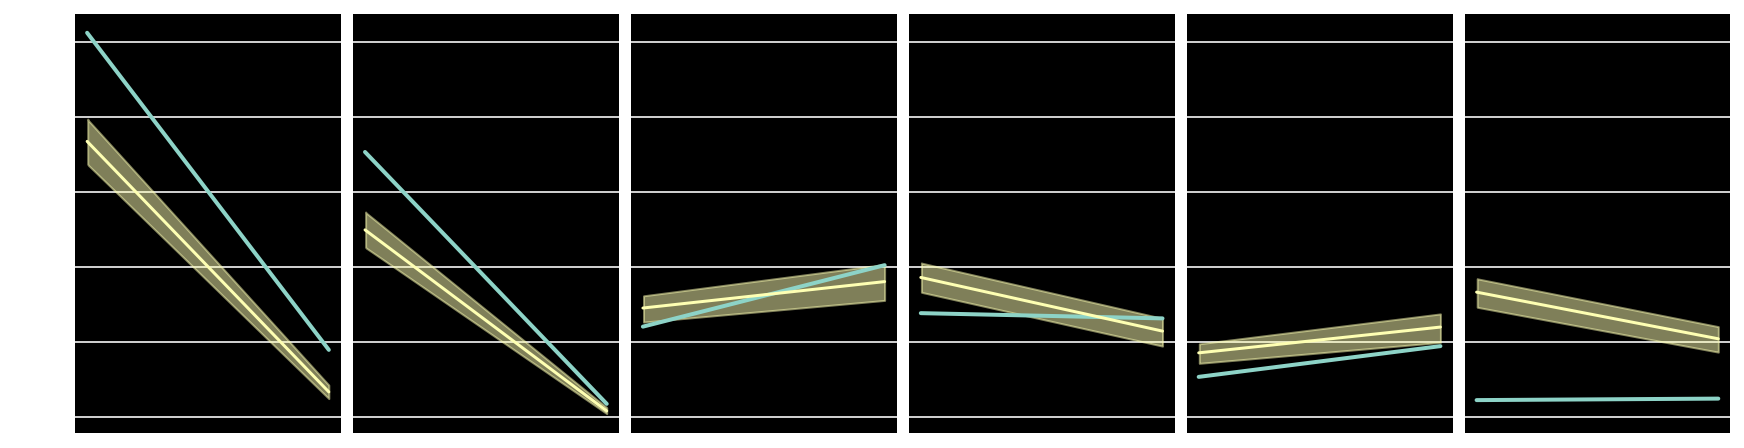

In [350]:
## observed admit vs predicted admit (which in this case = model p * observed applications)
_, ax = plt.subplots(1, len(depts), figsize=[12,3], sharey=True)
for i, x in enumerate(depts):
    ax[i].set_xticks([])
    ax[i].plot([0,1], d[(d["dept"]==x)]["admit"], lw=2)
    ax[i].plot([0,1], pp7.posterior_predictive["admit"][:,:,(deptid==i)].mean(["chain","draw"]))
    az.plot_hdi([0,1],pp7.posterior_predictive["admit"][:,:,(deptid==i)], ax=ax[i])

In [344]:
## gender + dept (additive effects, not interaction)
with pm.Model() as m8:
    a = pm.Normal("a", 0, 1.5, shape=len(genders))
    b = pm.Normal("b", 0, 1.5, shape=len(depts))
    p = pm.Deterministic("p", pm.math.invlogit(a[gid] + b[deptid]))
    admit = pm.Binomial("admit", d["applications"], p, observed=d["admit"])
    trace8 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


G -> A, G -> D -> A

m8 conditions on D

but, if unobserved U: G -> A, G -> D -> A, D <- U -> A, then D is a collider

In [351]:
az.summary(trace8, var_names=["~p"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a[0] -0.527  0.475  -1.460    0.302      0.023    0.016     439.0     530.0   
a[1] -0.429  0.474  -1.373    0.391      0.023    0.016     440.0     538.0   
b[0]  1.109  0.478   0.272    2.049      0.023    0.016     445.0     550.0   
b[1]  1.064  0.479   0.199    1.985      0.023    0.016     445.0     548.0   
b[2] -0.152  0.477  -0.995    0.778      0.023    0.016     440.0     534.0   
b[3] -0.185  0.477  -1.008    0.768      0.023    0.016     441.0     553.0   
b[4] -0.627  0.479  -1.415    0.365      0.023    0.016     450.0     563.0   
b[5] -2.185  0.492  -3.133   -1.291      0.023    0.016     466.0     642.0   

      r_hat  
a[0]   1.01  
a[1]   1.01  
b[0]   1.01  
b[1]   1.01  
b[2]   1.01  
b[3]   1.01  
b[4]   1.01  
b[5]   1.01

In [352]:
trace8

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [353]:
## exp(a) is on proportional odds scale
## p is on the outcome scale (0 - 1 prob)

## use az.summary on derived values
az.summary({
    "diff_a": trace8.posterior["a"][:,:,0] - trace8.posterior["a"][:,:,1],
    "odds_m": np.exp(trace8.posterior["a"][:,:,0]),
    "odds_f": np.exp(trace8.posterior["a"][:,:,1]),
    "prop odds": np.exp(trace8.posterior["a"][:,:,0] - trace8.posterior["a"][:,:,1]),
    ## p_dim_0 is genders*departments
    "p_m": trace8.posterior["p"][:,:,(gid==0)].mean("p_dim_0"),
    "p_f": trace8.posterior["p"][:,:,(gid==1)].mean("p_dim_0"),
    "diff_p": trace8.posterior["p"][:,:,(gid==0)].mean("p_dim_0") - trace8.posterior["p"][:,:,(gid==1)].mean("p_dim_0")
    }, kind="stats")

mean     sd  hdi_3%  hdi_97%
diff_a    -0.099  0.080  -0.252    0.047
odds_m     0.659  0.321   0.197    1.263
odds_f     0.728  0.355   0.208    1.373
prop odds  0.909  0.073   0.772    1.042
p_m        0.373  0.009   0.356    0.389
p_f        0.392  0.011   0.371    0.413
diff_p    -0.019  0.015  -0.048    0.009

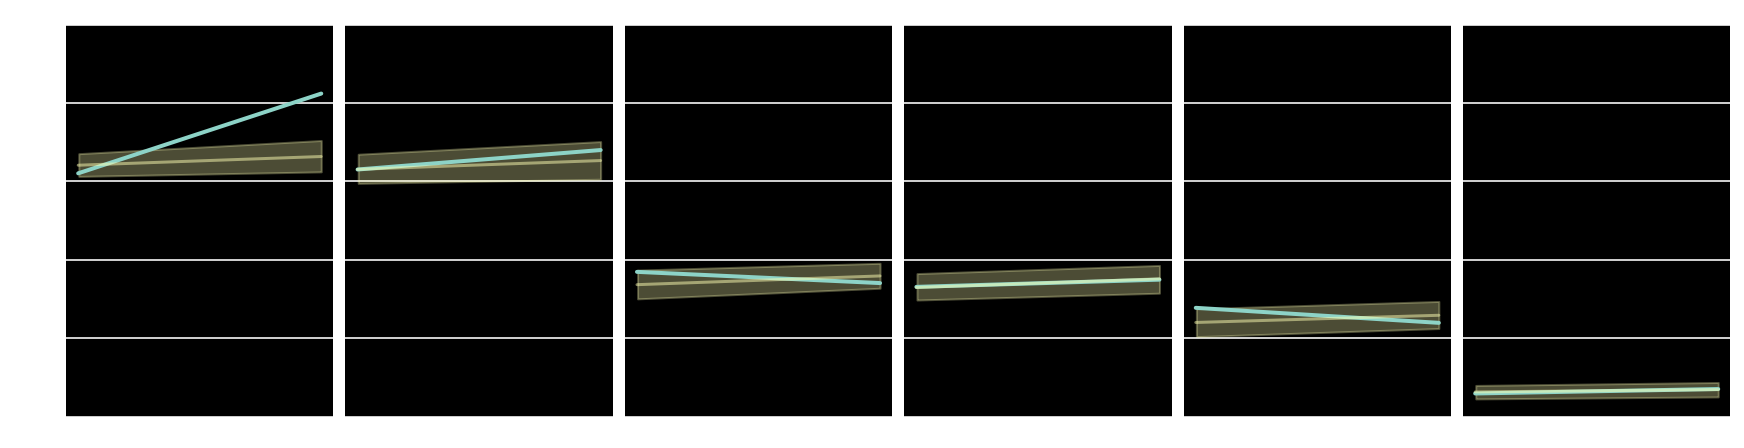

In [364]:
## observed p vs model p
_, ax = plt.subplots(1, len(depts), figsize=[12,3], sharey=True)
for i, x in enumerate(depts):
    ax[i].set_xticks([])
    ax[i].set_ylim(0,1)
    ax[i].plot([0,1], d[(d["dept"]==x)]["admit"] / d[(d["dept"]==x)]["applications"], lw=2)
    ax[i].plot([0,1], trace8.posterior["p"][:,:,(deptid==i)].mean(["chain","draw"]), alpha=0.5)
    az.plot_hdi([0,1],trace8.posterior["p"][:,:,(deptid==i)], ax=ax[i], fill_kwargs={"alpha": 0.3})

In [355]:
pp8 = pm.sample_posterior_predictive(trace8, model=m8, var_names=["admit"])

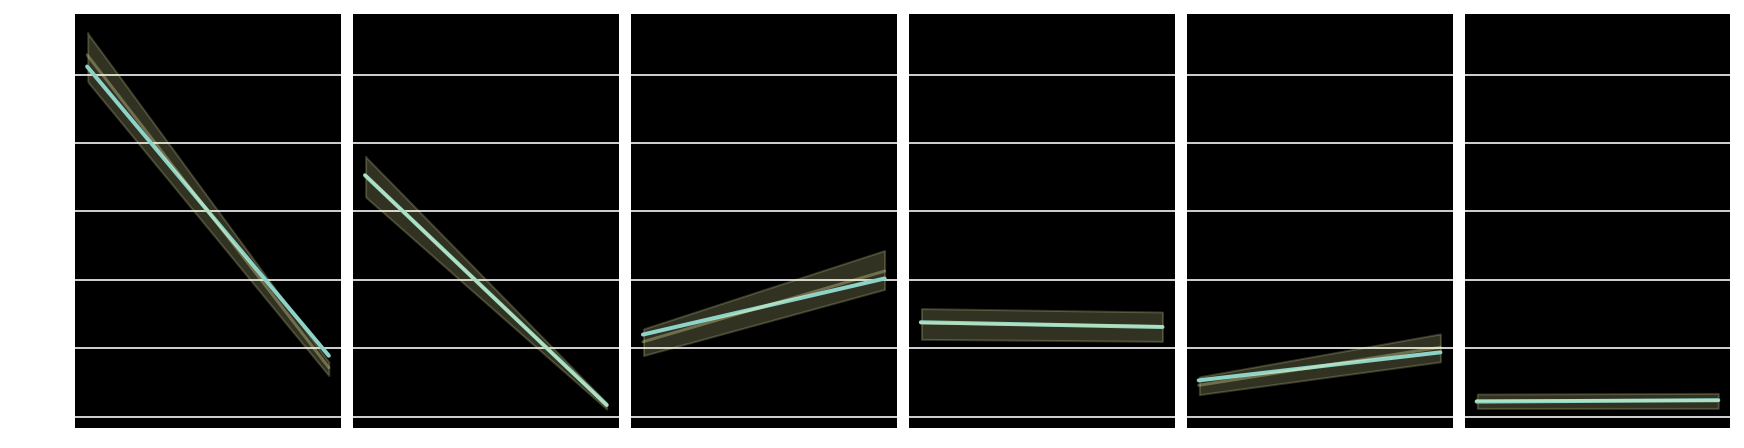

In [366]:
## observed admit vs predicted admit (which in this case = model p * observed applications)
_, ax = plt.subplots(1, len(depts), figsize=[12,3], sharey=True)
for i, x in enumerate(depts):
    ax[i].set_xticks([])
    ax[i].plot([0,1], d[(d["dept"]==x)]["admit"], lw=2)
    ax[i].plot([0,1], pp8.posterior_predictive["admit"][:,:,(deptid==i)].mean(["chain","draw"]), alpha=0.3)
    az.plot_hdi([0,1],pp8.posterior_predictive["admit"][:,:,(deptid==i)], ax=ax[i], fill_kwargs={"alpha": 0.2})

11.2 poisson regression

In [4]:
d = pd.read_csv("Data/Kline2.csv", sep=',')
d

culture  population contact  total_tools  mean_TU   lat    lon  lon2  \
0    Malekula        1100     low           13      3.2 -16.3  167.5 -12.5   
1     Tikopia        1500     low           22      4.7 -12.3  168.8 -11.2   
2  Santa Cruz        3600     low           24      4.0 -10.7  166.0 -14.0   
3         Yap        4791    high           43      5.0   9.5  138.1 -41.9   
4    Lau Fiji        7400    high           33      5.0 -17.7  178.1  -1.9   
5   Trobriand        8000    high           19      4.0  -8.7  150.9 -29.1   
6       Chuuk        9200    high           40      3.8   7.4  151.6 -28.4   
7       Manus       13000     low           28      6.6  -2.1  146.9 -33.1   
8       Tonga       17500    high           55      5.4 -21.2 -175.2   4.8   
9      Hawaii      275000     low           71      6.6  19.9 -155.6  24.4   

      logpop  
0   7.003065  
1   7.313220  
2   8.188689  
3   8.474494  
4   8.909235  
5   8.987197  
6   9.126959  
7   9.472705  
8   9.769956  
9  12.524526

In [5]:
d["log_pop"] = np.log(d["population"])
d["P"] = stats.zscore(d["log_pop"])
d["cid"], contact_levels = d["contact"].factorize()
d

culture  population contact  total_tools  mean_TU   lat    lon  lon2  \
0    Malekula        1100     low           13      3.2 -16.3  167.5 -12.5   
1     Tikopia        1500     low           22      4.7 -12.3  168.8 -11.2   
2  Santa Cruz        3600     low           24      4.0 -10.7  166.0 -14.0   
3         Yap        4791    high           43      5.0   9.5  138.1 -41.9   
4    Lau Fiji        7400    high           33      5.0 -17.7  178.1  -1.9   
5   Trobriand        8000    high           19      4.0  -8.7  150.9 -29.1   
6       Chuuk        9200    high           40      3.8   7.4  151.6 -28.4   
7       Manus       13000     low           28      6.6  -2.1  146.9 -33.1   
8       Tonga       17500    high           55      5.4 -21.2 -175.2   4.8   
9      Hawaii      275000     low           71      6.6  19.9 -155.6  24.4   

      logpop    log_pop         P  cid  
0   7.003065   7.003065 -1.361332    0  
1   7.313220   7.313220 -1.147433    0  
2   8.188689   8.188689 -0.543664    0  
3   8.474494   8.474494 -0.346558    1  
4   8.909235   8.909235 -0.046737    1  
5   8.987197   8.987197  0.007029    1  
6   9.126959   9.126959  0.103416    1  
7   9.472705   9.472705  0.341861    0  
8   9.769956   9.769956  0.546861    1  
9  12.524526  12.524526  2.446558    0

poisson regression usually uses a log link function

X ~ Poisson(lam)  
lam = exp(a)  
a ~ ???

<AxesSubplot:>

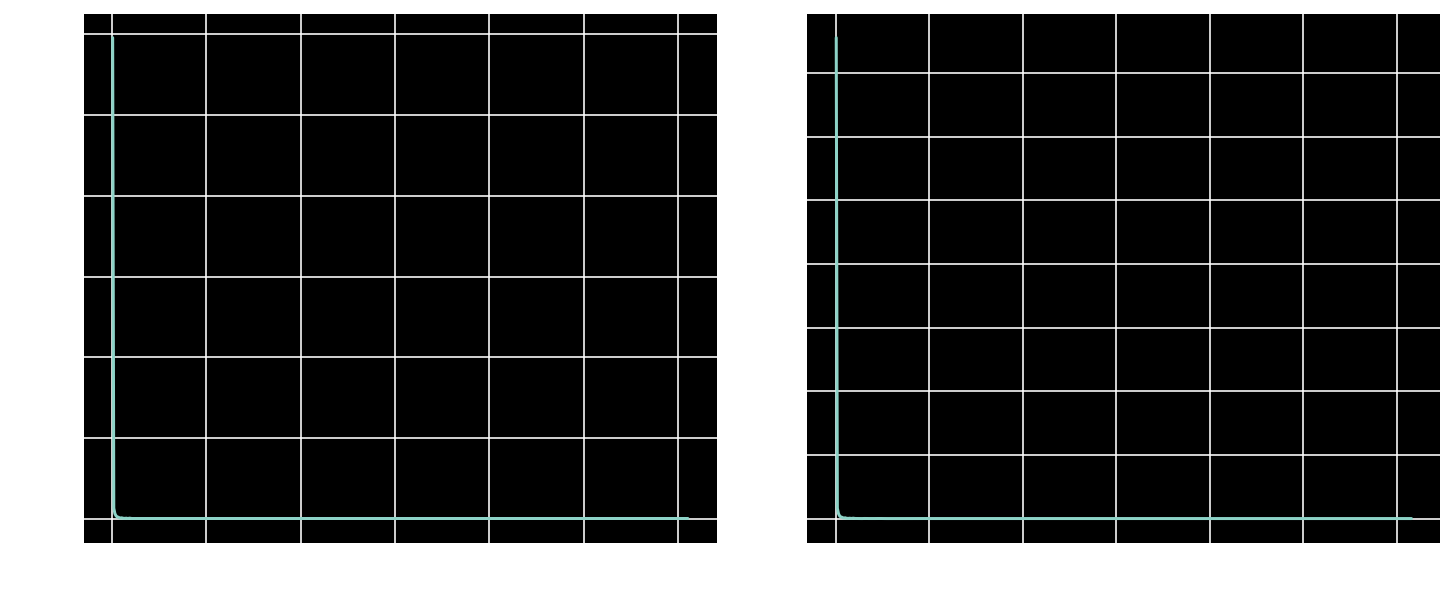

In [6]:
## a ~ Normal(0, 3)
_, ax = plt.subplots(1,2, figsize=[10,4])
x = np.exp(np.random.normal(0,3,10000))
az.plot_dist(x, ax=ax[0])
az.plot_kde(np.random.poisson(x, (100,10000)).flatten(), ax=ax[1])


<AxesSubplot:>

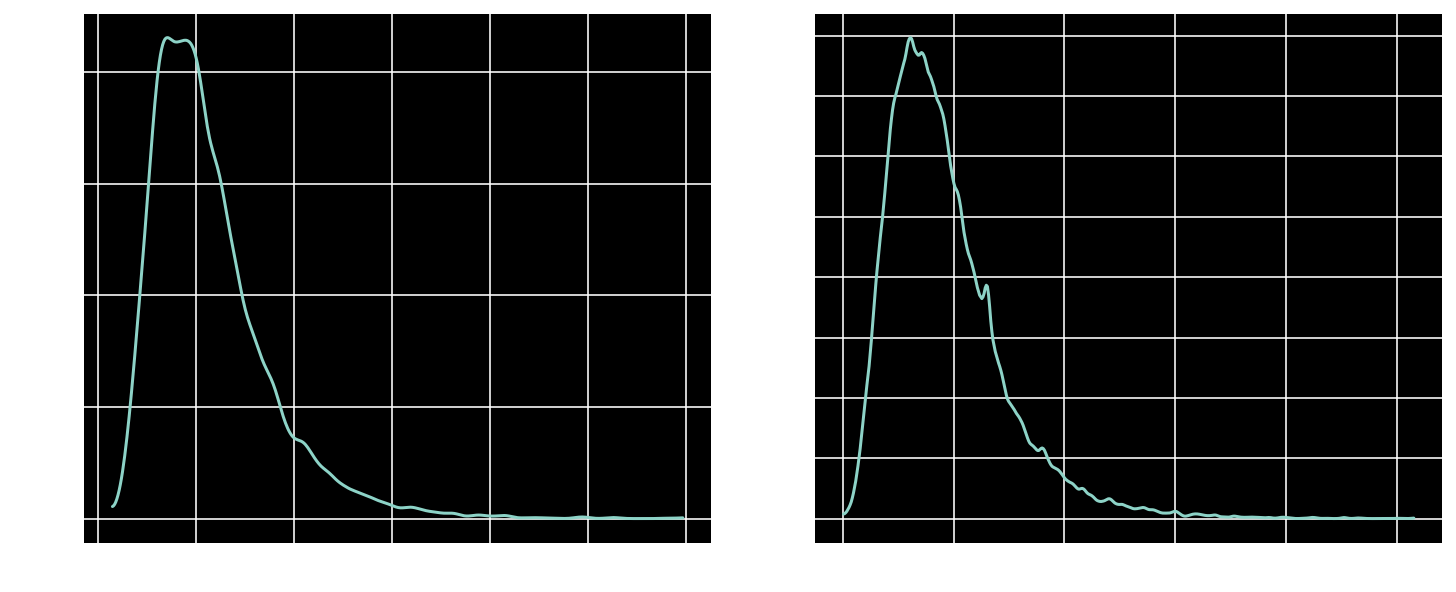

In [7]:
## a ~ Normal(3, 0.5)
_, ax = plt.subplots(1,2, figsize=[10,4])
x = np.exp(np.random.normal(3,0.5,10000))
az.plot_dist(x, ax=ax[0])
az.plot_kde(np.random.poisson(x, (3,10000)).flatten(), ax=ax[1])

log(lam) = a + bx  
b ~ ???

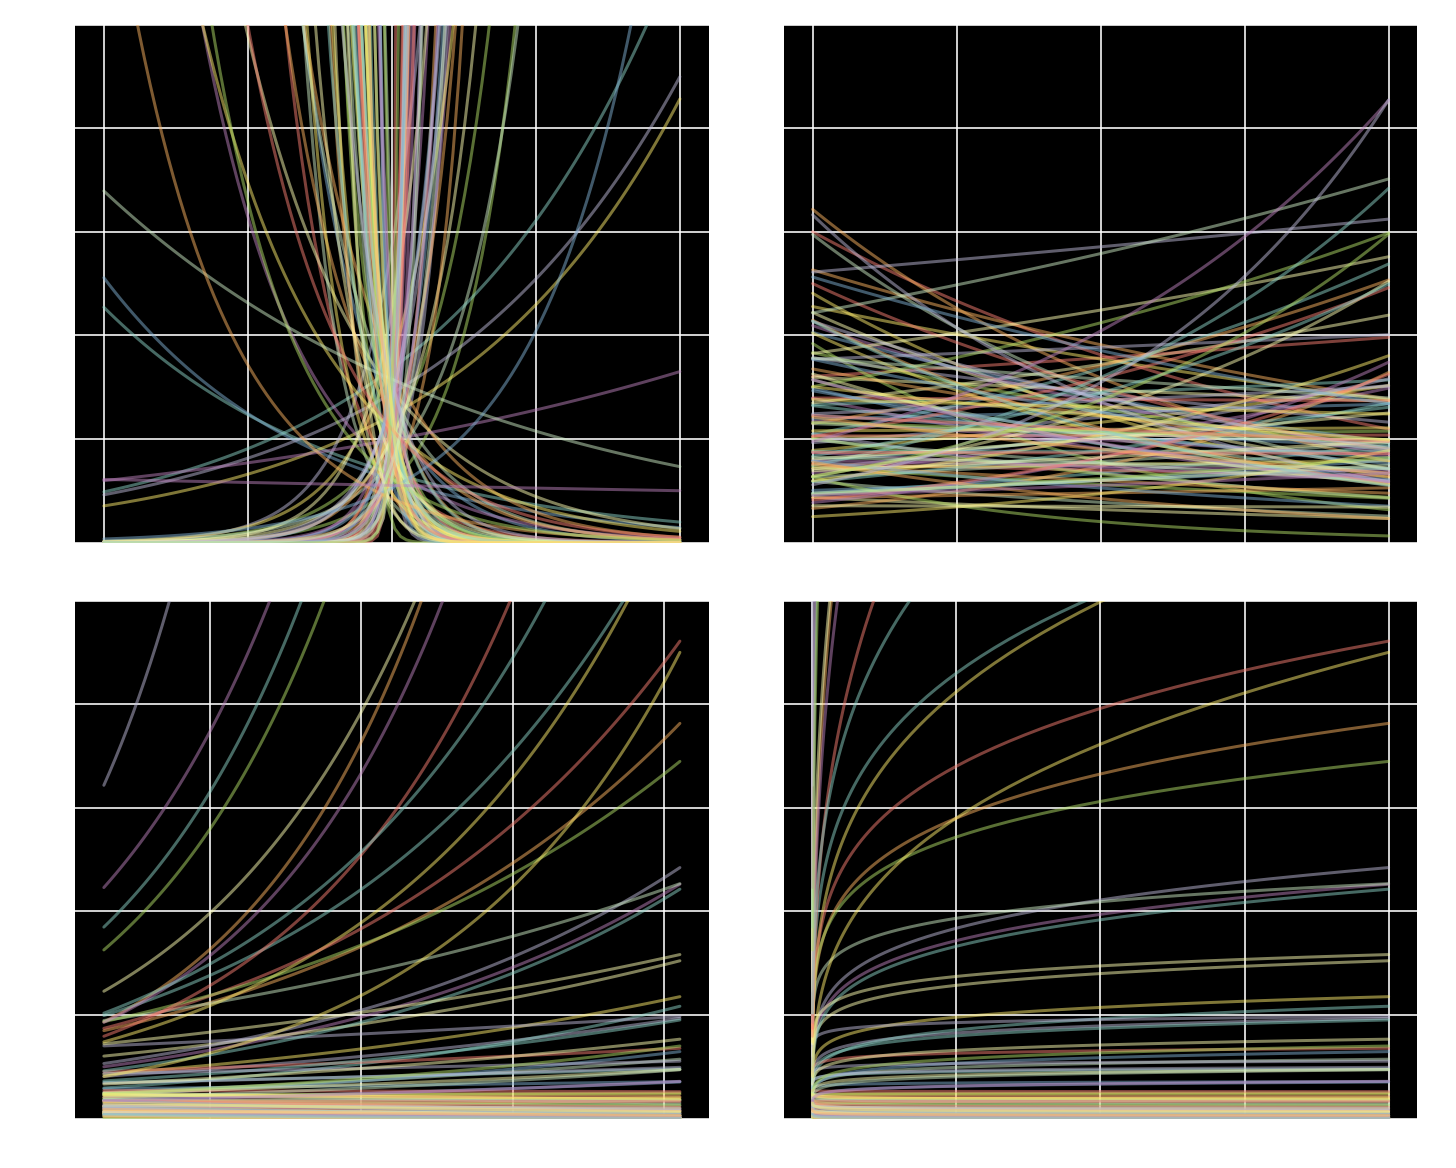

In [21]:
## b ~ Normal(0, 10)
n = 100
a = np.random.normal(3, 0.5, n)
b = np.random.normal(0, 10, n)

_, ax = plt.subplots(2, 2, figsize=[10, 8])
x = np.linspace(-2, 2, 100)
ax[0,0].set_ylim(0, 100)
for i in range(n):
    ax[0,0].plot(x, np.exp(a[i] + b[i]*x), alpha=0.5)

## b ~ Normal(0, 0.2)
b = np.random.normal(0, 0.2, n)
ax[0,1].set_ylim(0, 100)
for i in range(n):
    ax[0,1].plot(x, np.exp(a[i] + b[i]*x), alpha=0.5)

## x = unstandardized log-pop
x = np.linspace(np.log(100), np.log(200000), 100)
ax[1,0].set_ylim(0, 500)
for i in range(n):
    ax[1,0].plot(x, np.exp(a[i] + b[i]*x), alpha=0.5)

## x on natural scale
ax[1,1].set_ylim(0, 500)
for i in range(n):
    ax[1,1].plot(np.exp(x), np.exp(a[i] + b[i]*x), alpha=0.5)

In [24]:
## single intercept
with pm.Model() as m9:
    a = pm.Normal("a", 3.0, 0.5)
    ## link fn: log(lam) = a
    lam = pm.Deterministic("lam", pm.math.exp(a))
    T = pm.Poisson("tools", lam, observed=d["total_tools"])
    trace9 = pm.sample()

## separate intercept for each contact level
with pm.Model() as m9a:
    a = pm.Normal("a", 3.0, 0.5, shape=len(contact_levels))
    ## link fn: log(lam) = a
    lam = pm.Deterministic("lam", pm.math.exp( a[d["cid"]] ))
    T = pm.Poisson("tools", lam, observed=d["total_tools"])
    trace9a = pm.sample()

## contact level effect + a single slope for population: no interaction
with pm.Model() as m9b:
    a = pm.Normal("a", 3.0, 0.5, shape=len(contact_levels))
    b = pm.Normal("b", 0, 0.2)
    ## link fn: log(lam) = a + b*P
    lam = pm.Deterministic("lam", pm.math.exp( a[d["cid"]] + b*d["P"] ))
    T = pm.Poisson("tools", lam, observed=d["total_tools"])
    trace9b = pm.sample()

## interaction model: separate pop slope for each contact level
with pm.Model() as m10:
    a = pm.Normal("a", 3.0, 0.5, shape=len(contact_levels))
    b = pm.Normal("b", 0, 0.2, shape=len(contact_levels))
    ## link fn: log(lam) = a + b*P
    lam = pm.Deterministic("lam", pm.math.exp( a[d["cid"]] + b[d["cid"]] * d["P"] ))
    T = pm.Poisson("tools", lam, observed=d["total_tools"])
    trace10 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


In [81]:
az.compare({"m9": trace9, "m9a": trace9a, "m9b": trace9b, "m10": trace10}, 
ic="loo", scale="deviance", method="BB-pseudo-BMA")

/Users/sasha/miniforge3/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/sasha/miniforge3/lib/python3.9/site-packages/arviz/stats/stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/sasha/miniforge3/lib/python3.9/site-packages/arviz/stats/

rank         loo      p_loo      d_loo    weight         se        dse  \
m9b     0   80.226592   4.789837   0.000000  0.817204  30.220048   0.000000   
m10     1   85.212322   7.032881   4.985730  0.179334  42.905292   4.958024   
m9      2  141.464233   8.202149  61.237642  0.001977  10.113610  32.250338   
m9a     3  150.476088  16.848296  70.249496  0.001485  11.693415  44.912895   

     warning loo_scale  
m9b     True  deviance  
m10     True  deviance  
m9      True  deviance  
m9a     True  deviance

In [80]:
with pm.Model() as m10:
    a = pm.Normal("a", 3.0, 0.5, shape=len(contact_levels))
    b = pm.Normal("b", 0, 0.2, shape=len(contact_levels))
    cid = pm.MutableData("cid", d["cid"])
    P = pm.MutableData("P", d["P"])
    ## link fn: log(lam) = a + b*P
    lam = pm.Deterministic("lam", pm.math.exp( a[cid] + b[cid] * P ))
    T = pm.Poisson("tools", lam, observed=d["total_tools"])
    trace10 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.


In [99]:
P_seq = np.linspace(-5,3,100)
unscaled_P = np.exp(P_seq*d["log_pop"].std() + d["log_pop"].mean())
pm.set_data({"P": P_seq, "cid": np.repeat(0, 100)}, m10)
post10low = pm.sample_posterior_predictive(trace=trace10, model=m10, var_names=["lam","tools"])
pm.set_data({"P": P_seq, "cid": np.repeat(1, 100)}, m10)
post10high = pm.sample_posterior_predictive(trace=trace10, model=m10, var_names=["lam","tools"])

<AxesSubplot:>

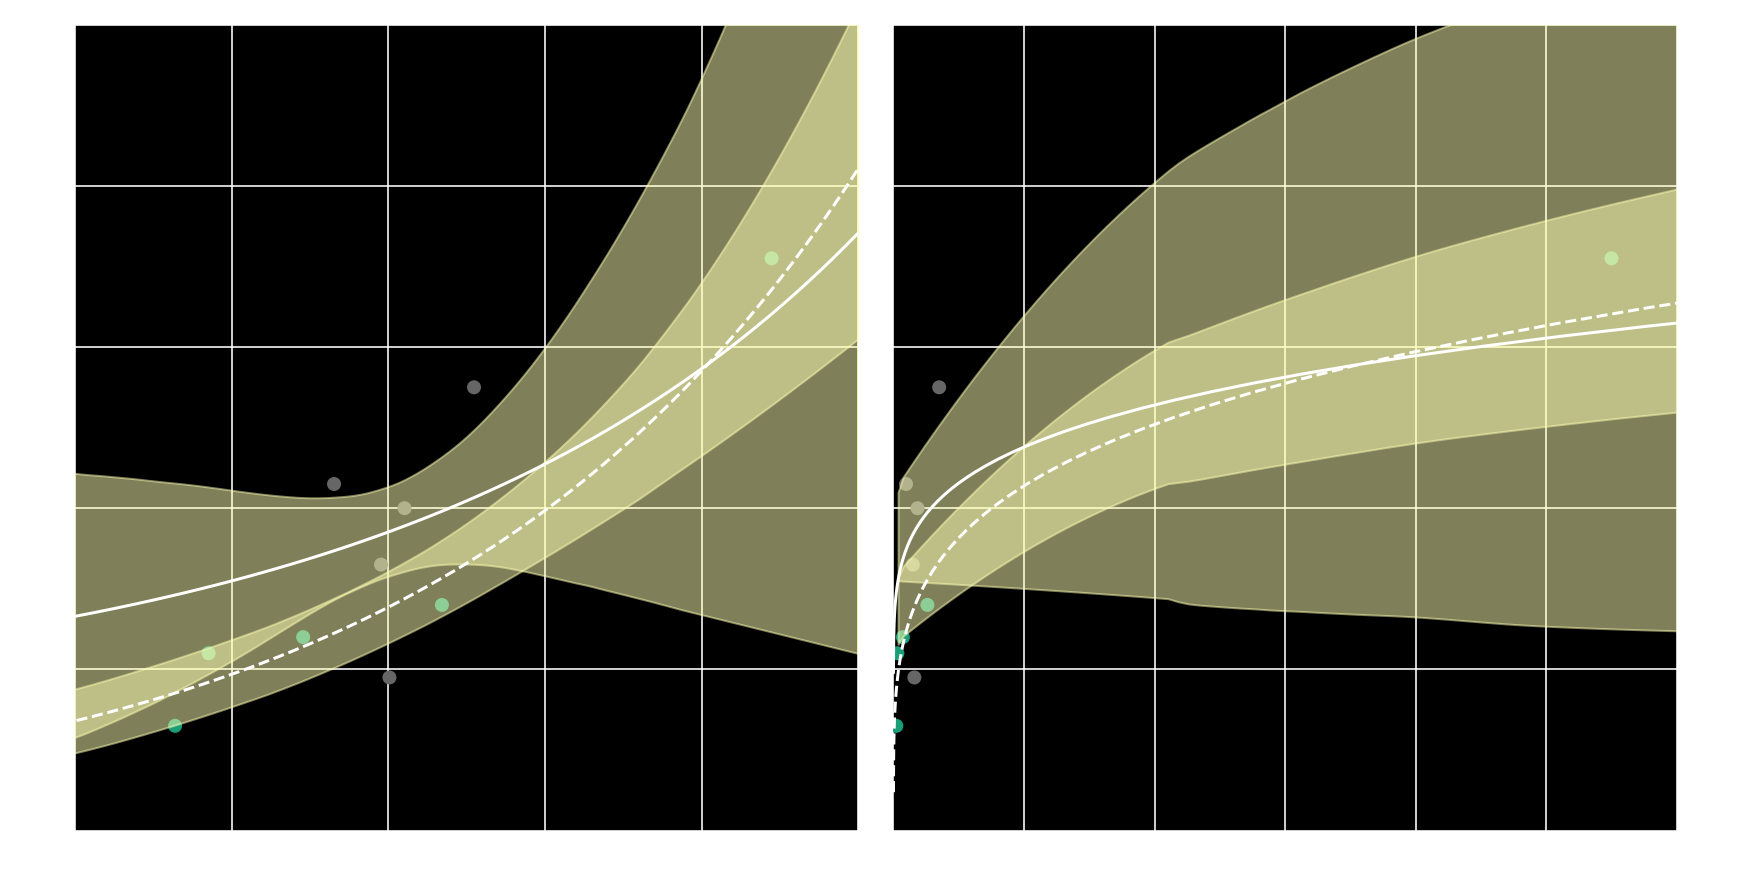

In [107]:
_, ax = plt.subplots(1, 2, figsize=[12,6], sharey=True)
ax[0].set_ylim(0,100)
ax[0].set_xlim(-2,3)
ax[0].scatter(d["P"], d["total_tools"], c=d["cid"], cmap="Dark2")
ax[0].plot(P_seq, post10low.posterior_predictive["lam"].mean(["chain","draw"]), "--w")
az.plot_hdi(P_seq, post10low.posterior_predictive["lam"], ax=ax[0])
ax[0].plot(P_seq, post10high.posterior_predictive["lam"].mean(["chain","draw"]), "-w")
az.plot_hdi(P_seq, post10high.posterior_predictive["lam"], ax=ax[0])

## on natural pop scale
ax[1].set_xlim(0, 300000)
ax[1].scatter(d["population"], d["total_tools"], c=d["cid"], cmap="Dark2")
ax[1].plot(unscaled_P, post10low.posterior_predictive["lam"].mean(["chain","draw"]), "--w")
az.plot_hdi(unscaled_P, post10low.posterior_predictive["lam"], ax=ax[1])
ax[1].plot(unscaled_P, post10high.posterior_predictive["lam"].mean(["chain","draw"]), "-w")
az.plot_hdi(unscaled_P, post10high.posterior_predictive["lam"], ax=ax[1])


modeling lambda (expected # of tools)

tools gained as a diminishing fn of population, lost linearly: deltaT = aP^b - gT   
when dT = 0, T = aP^b / g

In [179]:
## include interaction btw pop and contact level
with pm.Model() as m11:
    cid = pm.MutableData("cid", d["cid"])
    P = pm.MutableData("pop", d["population"])
    #P = pm.MutableData("log_pop", d["log_pop"])
    a_g = pm.LogNormal("a_g", mu=1, sigma=1, shape=len(contact_levels))
    b = pm.Exponential("b", 1, shape=len(contact_levels))
    #g = pm.Exponential("g", 1)
    ## no link fn this time, modeling lam directly
    lam = pm.Deterministic("lam", a_g[cid]*P**b[cid])
    T = pm.Poisson("tools", lam, observed=d["total_tools"])
    trace11 = pm.sample(tune=2000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_g, b]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 29 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


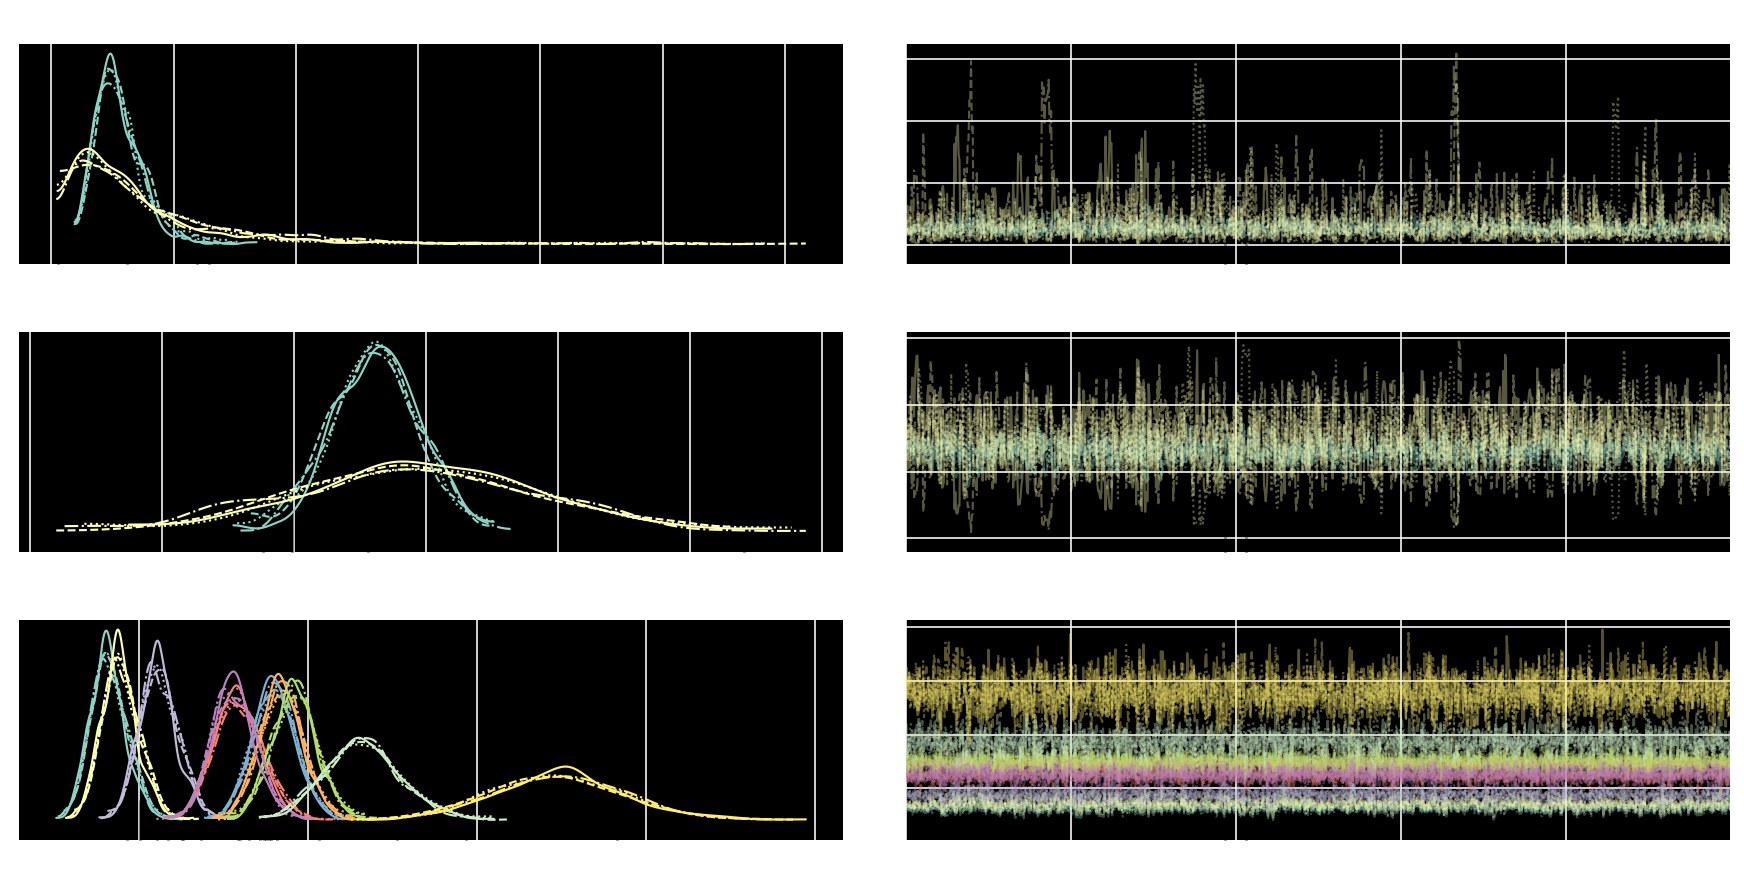

In [180]:
az.plot_trace(trace11);

In [181]:
az.summary(trace11, var_names=["~lam"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a_g[0]  2.799  1.002   1.187    4.650      0.031    0.023    1199.0    1052.0   
a_g[1]  3.762  3.695   0.194   10.090      0.154    0.121     977.0     716.0   
b[0]    0.261  0.033   0.199    0.324      0.001    0.001    1160.0    1080.0   
b[1]    0.294  0.094   0.121    0.472      0.003    0.002     973.0     677.0   

        r_hat  
a_g[0]   1.00  
a_g[1]   1.01  
b[0]     1.00  
b[1]     1.01

In [182]:
logp_seq = np.linspace(0,13,100)
natp_seq = np.int64(np.exp(logp_seq))
pm.set_data({"pop": natp_seq, "cid": np.repeat(0, 100)}, m11)
#pm.set_data({"log_pop": logp_seq, "cid": np.repeat(0, 100)}, m11)
post11low = pm.sample_posterior_predictive(trace=trace11, model=m11, var_names=["lam","tools"])
pm.set_data({"pop": natp_seq, "cid": np.repeat(1, 100)}, m11)
#pm.set_data({"log_pop": logp_seq, "cid": np.repeat(1, 100)}, m11)
post11high = pm.sample_posterior_predictive(trace=trace11, model=m11, var_names=["lam","tools"])


<AxesSubplot:>

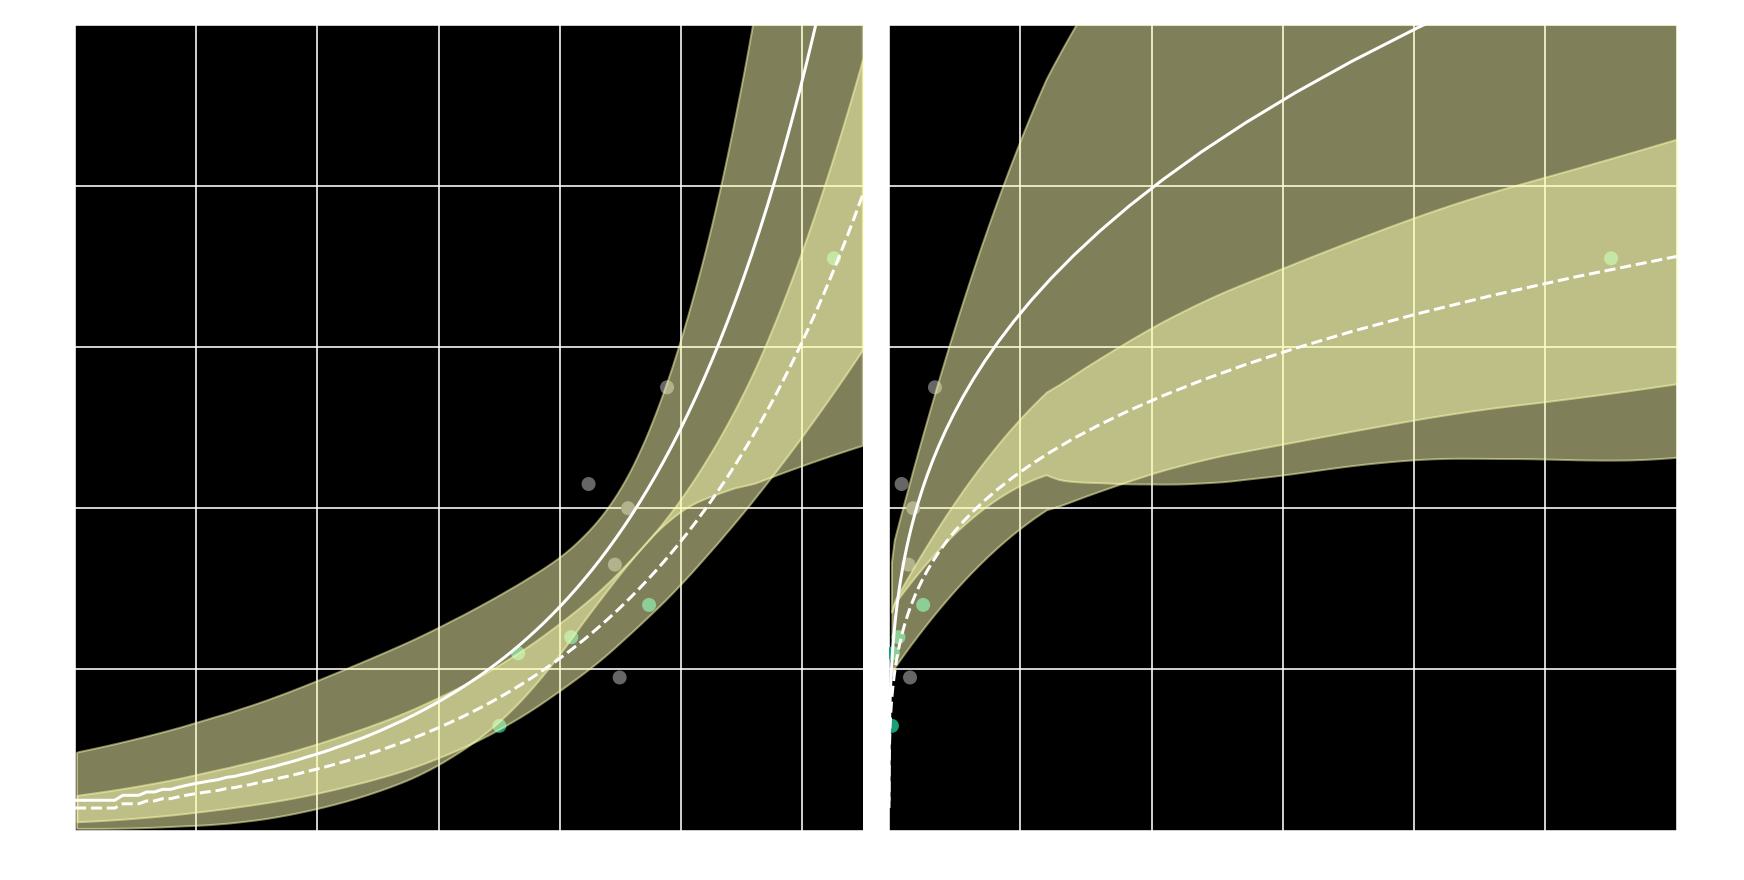

In [183]:
_, ax = plt.subplots(1, 2, figsize=[12,6], sharey=True)
ax[0].set_ylim(0,100)
ax[0].set_xlim(0,13)
ax[0].scatter(d["log_pop"], d["total_tools"], c=d["cid"], cmap="Dark2")
ax[0].plot(logp_seq, post11low.posterior_predictive["lam"].mean(["chain","draw"]), "--w")
az.plot_hdi(logp_seq, post11low.posterior_predictive["lam"], ax=ax[0])
ax[0].plot(logp_seq, post11high.posterior_predictive["lam"].mean(["chain","draw"]), "-w")
az.plot_hdi(logp_seq, post11high.posterior_predictive["lam"], ax=ax[0])

## on natural pop scale
ax[1].set_xlim(0, 300000)
ax[1].scatter(d["population"], d["total_tools"], c=d["cid"], cmap="Dark2")
ax[1].plot(natp_seq, post11low.posterior_predictive["lam"].mean(["chain","draw"]), "--w")
az.plot_hdi(natp_seq, post11low.posterior_predictive["lam"], ax=ax[1])
ax[1].plot(natp_seq, post11high.posterior_predictive["lam"].mean(["chain","draw"]), "-w")
az.plot_hdi(natp_seq, post11high.posterior_predictive["lam"], ax=ax[1])

multinomial regression

In [308]:
n = 1000
income = np.array([1.0,2.0,3.0,5.0,6.0,9.0])
intercepts = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
score = intercepts + 0.5 * income
pchoice = softmax(score)
career = np.random.choice(len(income), n, True, pchoice)

In [309]:
with pm.Model() as m13:
    ## intercepts relative to one of the categories
    a = pm.Normal("a", 0, 1, shape=len(income)-1)
    ## a single slope for effect of income on choice
    b = pm.Normal("b", 0, 2)
    ## linear model for score
    ss = [a[0] + b*income[0],
        a[1] + b*income[1],
        a[2] + b*income[2],
        a[3] + b*income[3],
        a[4] + b*income[4],
        0.0 + b*income[5]]
    s = pm.math.stack(ss)
    p = pm.Deterministic("p", pm.math.softmax(s))
    C = pm.Categorical("career", p=p, observed=career)
    trace13 = pm.sample(tune=2000,target_accept=0.9)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 12 seconds.


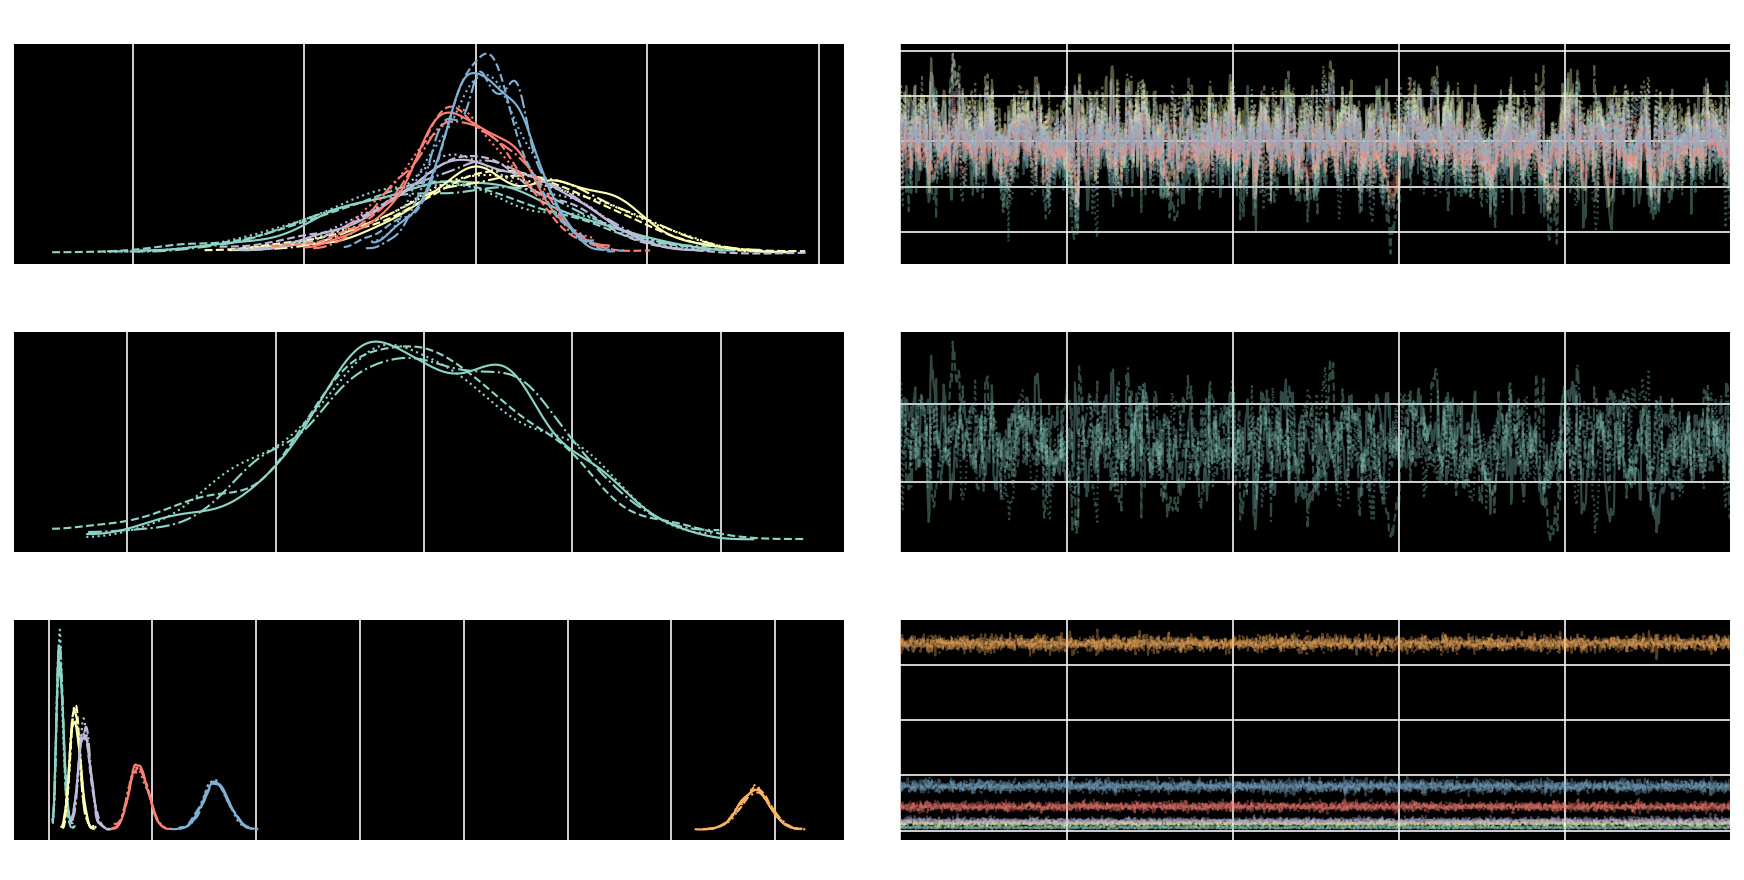

In [310]:
az.plot_trace(trace13);

In [311]:
az.summary(trace13)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a[0] -0.182  0.649  -1.356    1.073      0.027    0.019     599.0     730.0   
a[1]  0.179  0.559  -0.822    1.272      0.024    0.017     564.0     673.0   
a[2] -0.005  0.488  -0.932    0.881      0.021    0.015     541.0     632.0   
a[3] -0.081  0.329  -0.701    0.527      0.014    0.010     551.0     661.0   
a[4]  0.043  0.248  -0.407    0.528      0.011    0.008     545.0     660.0   
b     0.496  0.078   0.348    0.640      0.003    0.002     518.0     596.0   
p[0]  0.011  0.003   0.006    0.017      0.000    0.000    4510.0    3040.0   
p[1]  0.026  0.005   0.016    0.034      0.000    0.000    4811.0    3124.0   
p[2]  0.035  0.006   0.025    0.046      0.000    0.000    5122.0    3010.0   
p[3]  0.087  0.009   0.071    0.104      0.000    0.000    5836.0    3104.0   
p[4]  0.161  0.012   0.139    0.184      0.000    0.000    5231.0    2753.0   
p[5]  0.680  0.014   0.653    0.708      0.000    0.000    4934.0    3164.0   

      r_hat  
a[0]   1.00  
a[1]   1.00  
a[2]   1.00  
a[3]   1.01  
a[4]   1.01  
b      1.00  
p[0]   1.00  
p[1]   1.00  
p[2]   1.00  
p[3]   1.00  
p[4]   1.00  
p[5]   1.00

In [312]:
pchoice

array([0.01257281, 0.02072906, 0.03417645, 0.09290121, 0.1531682 ,
       0.68645226])

multinomial using poisson

In [331]:
with pm.Model() as mp:
    a = pm.Normal("a", 0, 1, shape=len(income)-1)
    b = pm.Normal("b", 0, 2)
    lam0 = pm.Deterministic("lam0", pm.math.exp(a[0] + b * income[0]))
    lam1 = pm.Deterministic("lam1", pm.math.exp(a[1] + b * income[1]))
    lam2 = pm.Deterministic("lam2", pm.math.exp(a[2] + b * income[2]))
    lam3 = pm.Deterministic("lam3", pm.math.exp(a[3] + b * income[3]))
    lam4 = pm.Deterministic("lam4", pm.math.exp(a[4] + b * income[4]))
    lam5 = pm.Deterministic("lam5", pm.math.exp( 0.0 + b * income[5]))

    c0 = pm.Poisson("c0", lam0, observed=np.sum(career==0))
    c1 = pm.Poisson("c1", lam1, observed=np.sum(career==1))
    c2 = pm.Poisson("c2", lam2, observed=np.sum(career==2))
    c3 = pm.Poisson("c3", lam3, observed=np.sum(career==3))
    c4 = pm.Poisson("c4", lam4, observed=np.sum(career==4))
    c5 = pm.Poisson("c5", lam5, observed=np.sum(career==5))

    tracep = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


In [332]:
az.summary(tracep)

mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a[0]    1.477   0.317    0.908    2.101      0.004    0.003    5694.0   
a[1]    1.718   0.195    1.359    2.084      0.003    0.002    5338.0   
a[2]    1.327   0.172    1.002    1.651      0.002    0.002    6210.0   
a[3]    0.826   0.112    0.630    1.054      0.002    0.001    5563.0   
a[4]    0.723   0.085    0.565    0.875      0.001    0.001    3903.0   
b       0.725   0.004    0.717    0.733      0.000    0.000    3873.0   
lam0    9.499   2.967    4.284   15.003      0.039    0.029    5692.0   
lam1   24.212   4.655   15.398   32.639      0.064    0.046    5343.0   
lam2   33.654   5.698   23.292   44.655      0.071    0.052    6410.0   
lam3   86.178   9.445   68.668  104.219      0.120    0.087    6115.0   
lam4  160.117  12.883  137.560  185.469      0.183    0.129    4958.0   
lam5  681.672  26.057  634.150  730.836      0.419    0.296    3873.0   

      ess_tail  r_hat  
a[0]    2861.0    1.0  
a[1]    3312.0    1.0  
a[2]    3361.0    1.0  
a[3]    3118.0    1.0  
a[4]    3004.0    1.0  
b       3162.0    1.0  
lam0    2841.0    1.0  
lam1    3350.0    1.0  
lam2    3304.0    1.0  
lam3    3306.0    1.0  
lam4    3451.0    1.0  
lam5    3162.0    1.0

In [333]:
post_sum_lam = tracep.posterior["lam0"] + tracep.posterior["lam1"] + tracep.posterior["lam2"] + tracep.posterior["lam3"] + tracep.posterior["lam4"] + tracep.posterior["lam5"]
post_p0 = tracep.posterior["lam0"] / post_sum_lam
post_p1 = tracep.posterior["lam1"] / post_sum_lam
post_p2 = tracep.posterior["lam2"] / post_sum_lam
post_p3 = tracep.posterior["lam3"] / post_sum_lam
post_p4 = tracep.posterior["lam4"] / post_sum_lam
post_p5 = tracep.posterior["lam5"] / post_sum_lam

print(pchoice)

az.summary({"p0": post_p0,
    "p1": post_p1,
    "p2": post_p2,
    "p3": post_p3,
    "p4": post_p4,
    "p5": post_p5})



[0.01257281 0.02072906 0.03417645 0.09290121 0.1531682  0.68645226]


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
p0  0.010  0.003   0.004    0.015        0.0      0.0    5717.0    3088.0   
p1  0.024  0.005   0.016    0.033        0.0      0.0    5387.0    3242.0   
p2  0.034  0.006   0.023    0.044        0.0      0.0    6058.0    3248.0   
p3  0.087  0.009   0.070    0.104        0.0      0.0    5486.0    3318.0   
p4  0.161  0.012   0.138    0.182        0.0      0.0    4045.0    3320.0   
p5  0.685  0.015   0.658    0.712        0.0      0.0    3362.0    3040.0   

    r_hat  
p0    1.0  
p1    1.0  
p2    1.0  
p3    1.0  
p4    1.0  
p5    1.0

beta distribution (beta binomial)

In [13]:
d = pd.read_csv("Data/UCBadmit.csv", sep=';')
d["gid"], genders = pd.factorize(d["applicant.gender"])

In [8]:
with pm.Model() as m121:
    a = pm.Normal("a", 0, 1.5, shape=len(genders))
    ## p = mean of beta = alpha / (alpha + beta)
    p = pm.Deterministic("p", pm.math.invlogit(a[d["gid"]]))
    ph = pm.Exponential("ph", 1)
    ## theta = kappa = concentration parameter = alpha + beta
    ## constrain to be >= 2.0
    th = pm.Deterministic("th", ph + 2.0)
    adm = pm.BetaBinomial("adm", n=d["applications"], alpha=p*th, beta=(1-p)*th, observed=d["admit"])
    trace121 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, ph]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.8856, but should be close to 0.8. Try to increase the number of tuning steps.


In [14]:
az.summary(trace121)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a[0]  -0.434  0.421  -1.197    0.383      0.008    0.007    2590.0    2305.0   
a[1]  -0.330  0.415  -1.054    0.508      0.008    0.006    2885.0    2667.0   
ph     1.050  0.804   0.003    2.500      0.015    0.010    2213.0    1400.0   
p[0]   0.397  0.097   0.222    0.581      0.002    0.001    2590.0    2305.0   
p[1]   0.421  0.097   0.234    0.597      0.002    0.001    2885.0    2667.0   
p[2]   0.397  0.097   0.222    0.581      0.002    0.001    2590.0    2305.0   
p[3]   0.421  0.097   0.234    0.597      0.002    0.001    2885.0    2667.0   
p[4]   0.397  0.097   0.222    0.581      0.002    0.001    2590.0    2305.0   
p[5]   0.421  0.097   0.234    0.597      0.002    0.001    2885.0    2667.0   
p[6]   0.397  0.097   0.222    0.581      0.002    0.001    2590.0    2305.0   
p[7]   0.421  0.097   0.234    0.597      0.002    0.001    2885.0    2667.0   
p[8]   0.397  0.097   0.222    0.581      0.002    0.001    2590.0    2305.0   
p[9]   0.421  0.097   0.234    0.597      0.002    0.001    2885.0    2667.0   
p[10]  0.397  0.097   0.222    0.581      0.002    0.001    2590.0    2305.0   
p[11]  0.421  0.097   0.234    0.597      0.002    0.001    2885.0    2667.0   
th     3.050  0.804   2.003    4.500      0.015    0.010    2213.0    1400.0   

       r_hat  
a[0]     1.0  
a[1]     1.0  
ph       1.0  
p[0]     1.0  
p[1]     1.0  
p[2]     1.0  
p[3]     1.0  
p[4]     1.0  
p[5]     1.0  
p[6]     1.0  
p[7]     1.0  
p[8]     1.0  
p[9]     1.0  
p[10]    1.0  
p[11]    1.0  
th       1.0